In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='darkgrid', context='talk')

import warnings
warnings.filterwarnings('ignore')

from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [2]:
data=pd.read_csv('data_cleaned.csv', parse_dates=['date'], index_col=0)
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1.900052e+09,2019-06-04,ZB00025746,1,9.412096,0.000000,9.412096,0.000000,9.412096,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1.900101e+09,2019-07-15,ZB00025746,1,8.648837,5.393411,8.648837,5.393411,3.255426,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1.900107e+09,2019-07-24,ZB00025746,1,8.648837,5.458527,8.648837,5.458527,3.190310,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1.900111e+09,2019-08-01,ZB00025746,1,8.648837,5.440310,8.648837,5.440310,3.208527,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1.900052e+09,2019-06-04,ZB00022010,1,12.784729,4.087597,12.784729,4.087597,8.697132,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [104]:
data=data[data['country']=='Slovakia']
data.shape

(241654, 16)

In [105]:
def select_series(data, time_period='day', revenue='net'):
    time_periods = {
        'day': 'D',
        'week': 'W',
        'month': 'M'}
    
    revenue_cat = {
        'net':'net_revenue',
        'gross':'gross_revenue',
        'margin':'margin_revenue'}
    
    data = data.set_index('date')
    data = data[revenue_cat[revenue]].resample(time_periods[time_period]).sum()
    data = pd.DataFrame(data).reset_index()
    return data

In [106]:
daily_sales=select_series(data)
daily_sales.columns=['ds', 'y']
daily_sales.ds=pd.to_datetime(daily_sales['ds'])
daily_sales.sort_values('ds')
daily_sales.head()

,ds,y
0,2019-06-01,22722.432248
1,2019-06-02,3372.280577
2,2019-06-03,5853.564452
3,2019-06-04,5277.819860
4,2019-06-05,4907.056860


In [107]:

train_df=daily_sales[:int(daily_sales.shape[0]*0.75)]

test_df=daily_sales[int(daily_sales.shape[0]*0.75):]
print(train_df.shape)
print(test_df.shape)

(530, 2)
(177, 2)


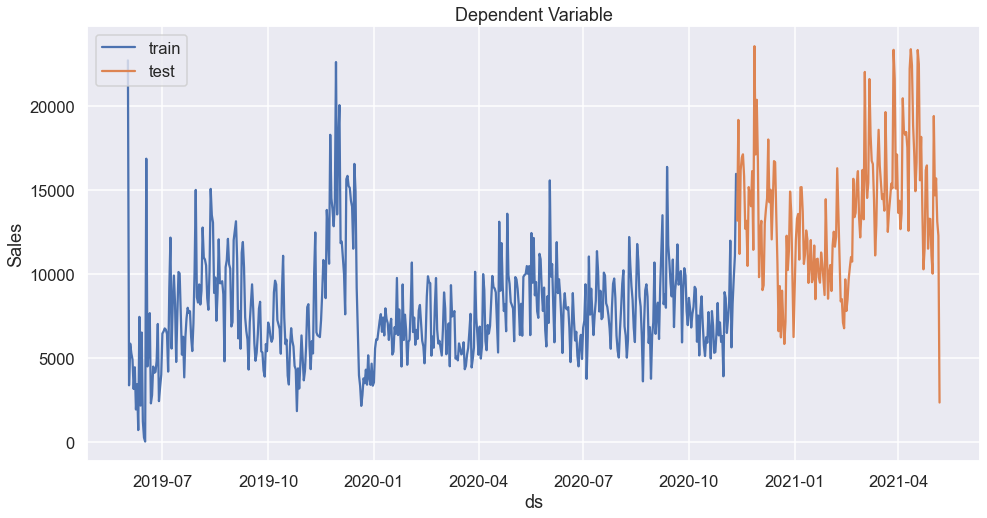

In [108]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(x='ds', y='y', label='train', data=train_df, ax=ax)
sns.lineplot(x='ds', y='y', label='test', data=test_df, ax=ax)

ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='Sales');

In [109]:
#training the model on training set
model=Prophet(weekly_seasonality=True, daily_seasonality=False, n_changepoints=3)
model.add_seasonality(name='monthly', period=30, fourier_order=1)
model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [110]:
future=model.make_future_dataframe(periods=207, freq='D')
forecast=model.predict(future)

In [111]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,monthly,monthly_lower,monthly_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-06-01,7349.457624,1460.881414,8795.917368,7349.457624,7349.457624,-2081.046733,-2081.046733,-2081.046733,-304.776418,-304.776418,-304.776418,-1776.270315,-1776.270315,-1776.270315,0.0,0.0,0.0,5268.410891
1,2019-06-02,7351.398005,4001.914061,11278.306322,7351.398005,7351.398005,301.849627,301.849627,301.849627,-284.141992,-284.141992,-284.141992,585.991619,585.991619,585.991619,0.0,0.0,0.0,7653.247632
2,2019-06-03,7353.338385,5067.850734,12366.275827,7353.338385,7353.338385,1319.907023,1319.907023,1319.907023,-251.089196,-251.089196,-251.089196,1570.996220,1570.996220,1570.996220,0.0,0.0,0.0,8673.245409
3,2019-06-04,7355.278766,4591.006232,11533.395577,7355.278766,7355.278766,664.774597,664.774597,664.774597,-207.062598,-207.062598,-207.062598,871.837195,871.837195,871.837195,0.0,0.0,0.0,8020.053362
4,2019-06-05,7357.219146,3879.446459,10737.333721,7357.219146,7357.219146,-103.320548,-103.320548,-103.320548,-153.986371,-153.986371,-153.986371,50.665823,50.665823,50.665823,0.0,0.0,0.0,7253.898598


In [112]:
# We want to look at yhat, yhat_lower, and yhat_upper only. 
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

,ds,yhat,yhat_lower,yhat_upper
0,2019-06-01,5268.410891,1460.881414,8795.917368
1,2019-06-02,7653.247632,4001.914061,11278.306322
2,2019-06-03,8673.245409,5067.850734,12366.275827
3,2019-06-04,8020.053362,4591.006232,11533.395577
4,2019-06-05,7253.898598,3879.446459,10737.333721


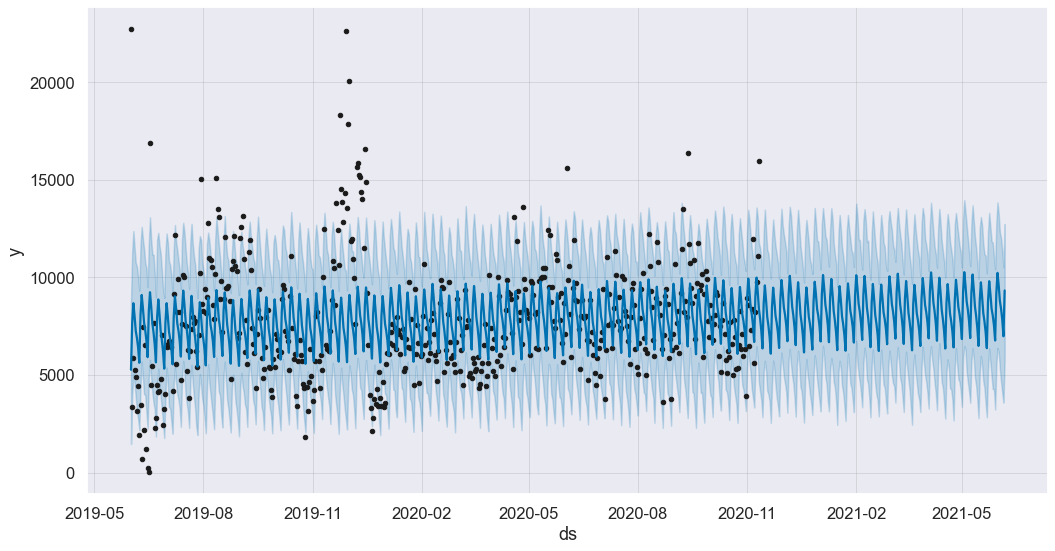

In [113]:
#ploting the forecast
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=model.plot(forecast, ax=ax)
plt.show()

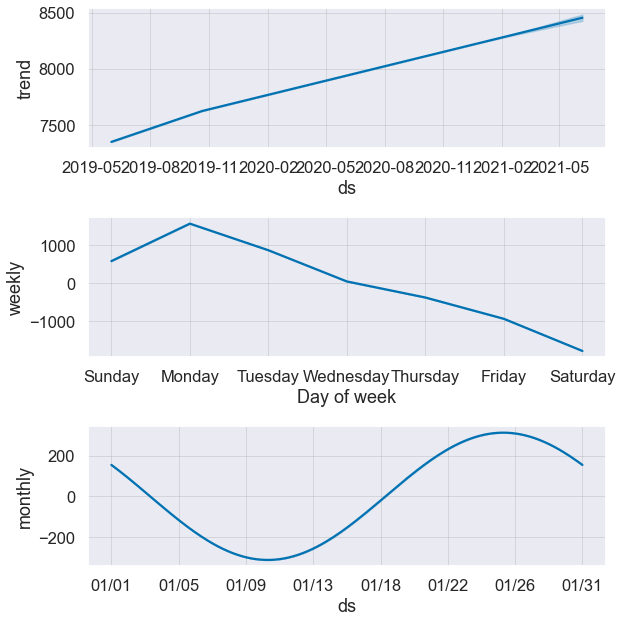

In [114]:
# ploting model components
model.plot_components(forecast)
plt.show()

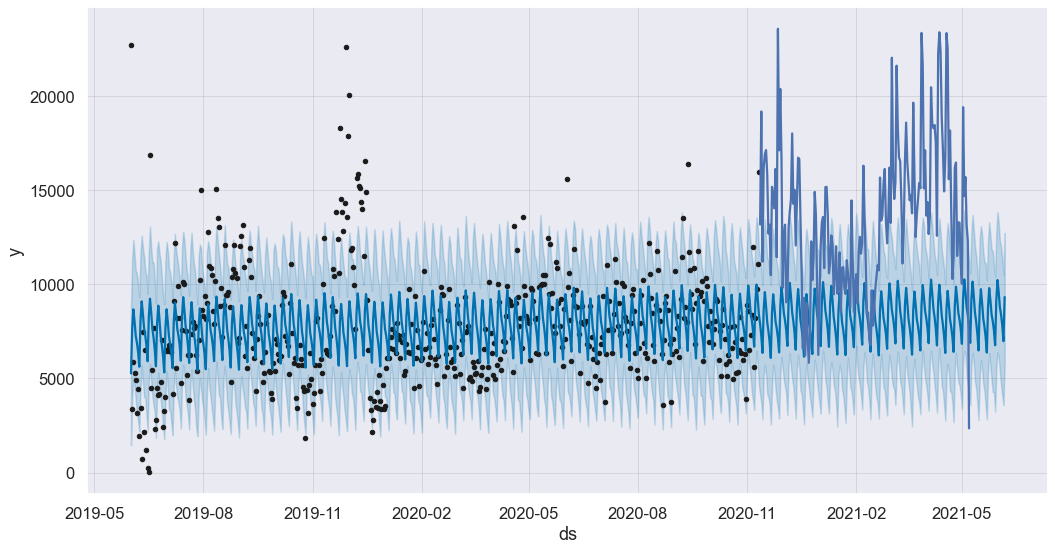

In [115]:
 # comparing Forecast to Actual

f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


fig=model.plot(forecast, ax=ax)
ax.plot(test_df.ds, test_df.y)



Text(0.5, 1.0, 'One Month Forecast Vs Actual, March 1 to 30, 2021')

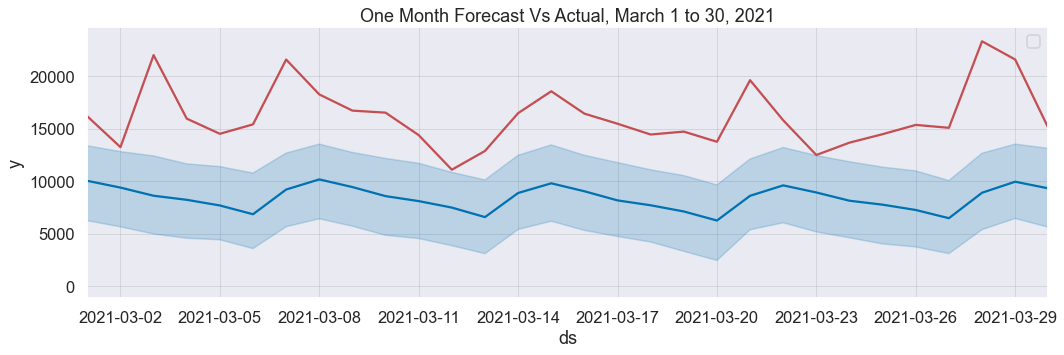

In [116]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-01', upper='2021-03-30')
plt.legend()
plt.title('One Month Forecast Vs Actual, March 1 to 30, 2021')



Text(0.5, 1.0, 'One month Forecast Vs Actual, April 07 to May 6 , 2021')

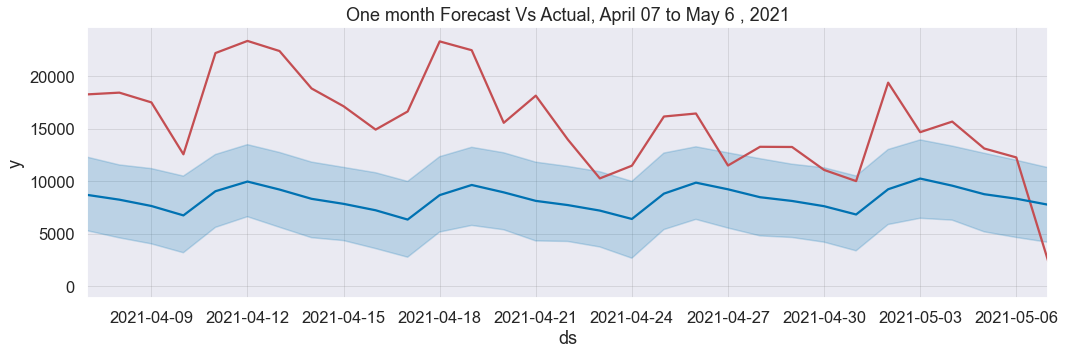

In [117]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')

plt.title('One month Forecast Vs Actual, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month Forecast, May 07 to June 6, 2021')

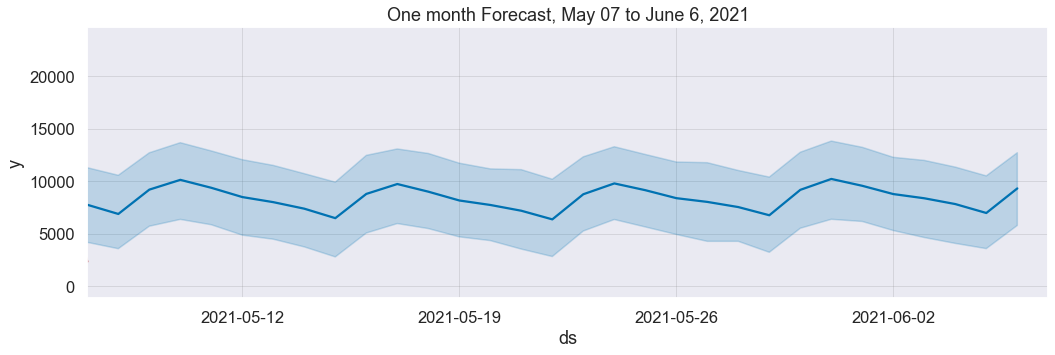

In [118]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-05-07', upper='2021-06-07')

plt.title('One month Forecast, May 07 to June 6, 2021')

Text(0.5, 1.0, 'One week Forecast Vs Actual, March 19 to 25, 2021')

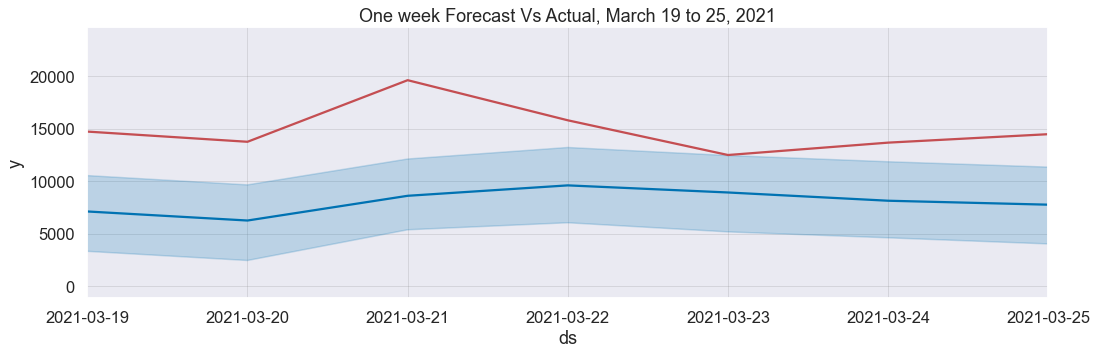

In [119]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = model.plot(forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')

plt.title('One week Forecast Vs Actual, March 19 to 25, 2021')


In [120]:
# Means Squared Error and RSME
predictions=forecast.yhat[-177:]
mse=mean_squared_error(test_df.y, predictions)
rmse=sqrt(mean_squared_error(test_df.y, predictions))
print('MSE: ', mse)
print('RMSE: ', rmse)

#Mean absolute percentage error (mape)

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Cross Validation
df_cv=cross_validation(model, horizon='30 days', initial='90', period='30 days')

mape=mean_absolute_percentage_error(df_cv.y, df_cv.yhat)
print('MAPE: ', mape)

# https://www.kaggle.com/robikscube/time-series-forecasting-with-prophet

INFO:fbprophet:Making 17 forecasts with cutoffs between 2019-06-20 00:00:00 and 2020-10-12 00:00:00


MSE:  43868080.25090064
RMSE:  6623.298290949959



MAPE:  65.44605055358139


In [121]:
df_cv.head()


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-06-21,3282.786351,-1596.073895,8456.895885,2296.225280,2019-06-20
1,2019-06-22,3306.755693,-1890.434640,7997.640109,2787.579008,2019-06-20
2,2019-06-23,-4037.088058,-9169.374590,792.136542,4487.705807,2019-06-20
3,2019-06-24,-365.662048,-5133.798186,4786.523651,4116.956389,2019-06-20
4,2019-06-25,-4753.659387,-9365.835236,-148.376019,4170.934566,2019-06-20


In [122]:
df_cv.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
505,2020-11-07,6863.497371,3273.109209,10286.523623,5630.748822,2020-10-12
506,2020-11-08,9186.673651,5693.740919,12856.972109,8221.977035,2020-10-12
507,2020-11-09,10169.949056,6324.850805,13915.909838,9749.592143,2020-10-12
508,2020-11-10,9483.655821,6010.784093,13070.929904,11097.170140,2020-10-12
509,2020-11-11,8446.814705,4654.595035,12032.419036,15964.877176,2020-10-12


In [123]:
### Performance Metrics
from fbprophet.diagnostics import performance_metrics
df_perf = performance_metrics(df_cv)
df_perf

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,6.541759e+06,2557.686243,1880.938381,0.318516,0.210300,0.862745
1,4 days,9.901883e+06,3146.725745,2260.121639,0.388466,0.210943,0.803922
2,5 days,1.356238e+07,3682.713012,2597.219018,0.463859,0.199526,0.764706
3,6 days,1.830606e+07,4278.557746,2977.839942,0.510569,0.248485,0.745098
4,7 days,2.578363e+07,5077.758225,3284.238242,0.534066,0.268741,0.745098
5,8 days,3.016506e+07,5492.272612,3404.084999,0.641204,0.268741,0.745098
6,9 days,3.501404e+07,5917.266485,3574.325181,0.731698,0.285501,0.745098
7,10 days,4.511884e+07,6717.055604,3763.224504,0.838812,0.263772,0.705882
8,11 days,5.772535e+07,7597.720078,4221.584506,0.785793,0.308132,0.666667
9,12 days,7.931425e+07,8905.855067,4760.127638,0.770310,0.279808,0.647059


Text(0.5, 1.0, ' Forecast Vs Actual')

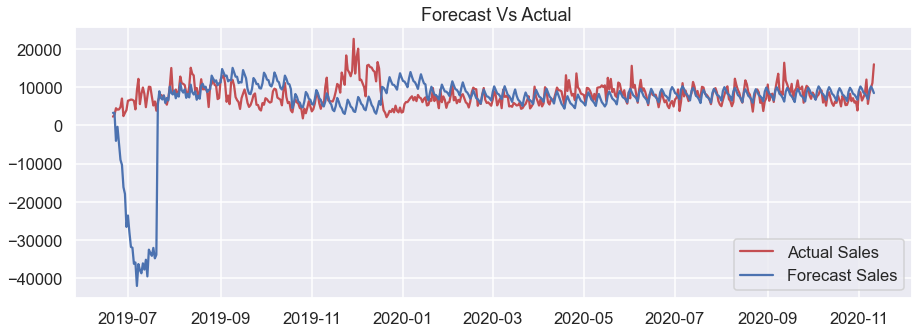

In [124]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(df_cv['ds'], df_cv['y'], color='r', label='Actual Sales')
ax.plot(df_cv['ds'], df_cv['yhat'], color='b', label='Forecast Sales')
plt.legend()



plt.title(' Forecast Vs Actual')

# Hyperparameter tuning

In [125]:
from sklearn.model_selection import ParameterGrid
params_grid = {'seasonality_mode':('multiplicative','additive'),
               'changepoint_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'holidays_prior_scale':[0.1,0.2,0.3,0.4,0.5],
              'n_changepoints' : [100,150,200]}
grid = ParameterGrid(params_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 150


In [126]:
import itertools
param_grid = {'seasonality_mode':('multiplicative','additive'),  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
             'n_changepoints' : [3, 6, 9, 12, 15, 18, 21, 24, 25, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    cutoffs=pd.to_datetime(['2020-03-03','2020-04-28'])
    m = Prophet(**params).fit(train_df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

#https://facebook.github.io/prophet/docs/diagnostics.html

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9f8d200460>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9f8dc7d790>
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9f8d6283a0>
INFO:fbprophet:Disabling yearly seaso

    seasonality_mode  changepoint_prior_scale  seasonality_prior_scale  \
0     multiplicative                    0.001                     0.01   
1     multiplicative                    0.001                     0.01   
2     multiplicative                    0.001                     0.01   
3     multiplicative                    0.001                     0.01   
4     multiplicative                    0.001                     0.01   
..               ...                      ...                      ...   
315         additive                    0.500                    10.00   
316         additive                    0.500                    10.00   
317         additive                    0.500                    10.00   
318         additive                    0.500                    10.00   
319         additive                    0.500                    10.00   

     n_changepoints          rmse  
0                 3  11084.217921  
1                 6  11430.750808  
2  

In [127]:

tuning_results.sort_values(by=['rmse'])

,seasonality_mode,changepoint_prior_scale,seasonality_prior_scale,n_changepoints,rmse
130,multiplicative,0.500,0.1,3,1287.132811
150,multiplicative,0.500,10.0,3,1299.857527
140,multiplicative,0.500,1.0,3,1300.370327
290,additive,0.500,0.1,3,1321.888192
310,additive,0.500,10.0,3,1324.908750
...,...,...,...,...,...
181,additive,0.001,1.0,6,11555.488940
171,additive,0.001,0.1,6,11635.079996
11,multiplicative,0.001,0.1,6,12034.475595
31,multiplicative,0.001,10.0,6,12042.237506


In [150]:
final_model=Prophet(growth='linear', daily_seasonality=True, seasonality_mode='multiplicative', seasonality_prior_scale=0.1, changepoint_prior_scale=0.500, n_changepoints=3)
final_model.add_seasonality(name='monthly', period=30, fourier_order=3)
final_model.fit(train_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [151]:
future=final_model.make_future_dataframe(periods=test_df.shape[0]+30, freq='D')
final_forecast=final_model.predict(future)

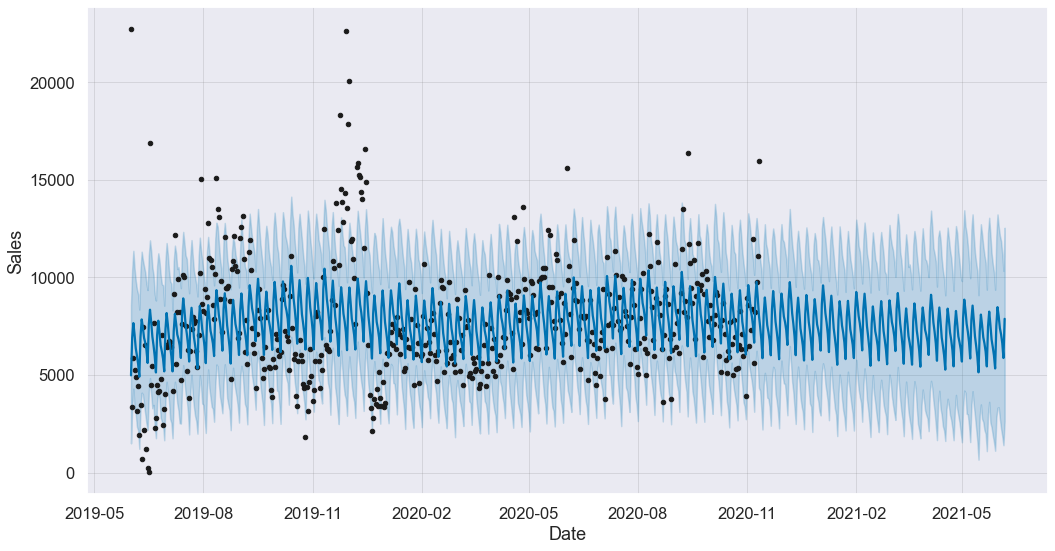

In [152]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)

fig=final_model.plot(final_forecast, ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

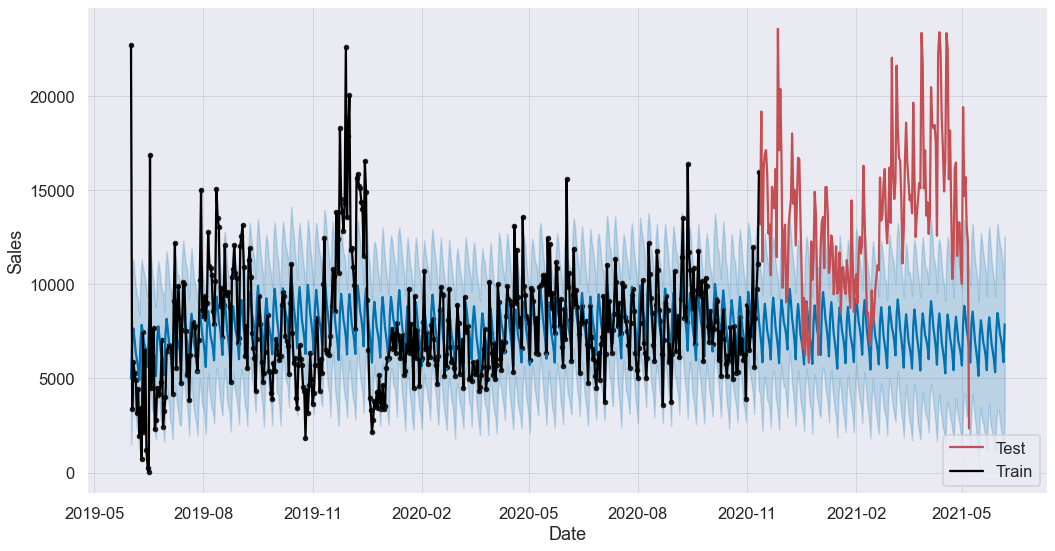

In [153]:
f, ax=plt.subplots(1)
f.set_figheight(8)
f.set_figwidth(15)


final_model.plot(final_forecast, ax=ax)
ax.plot(test_df.ds, test_df.y, color='r', label='Test')
ax.plot(train_df.ds, train_df.y, color='black', label='Train')
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

Text(0.5, 1.0, 'Forecast VS Actual Daily Sales')

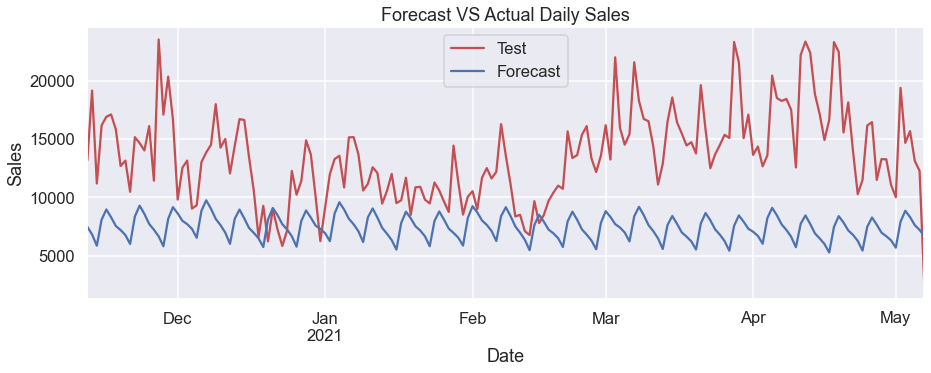

In [154]:
# Plot the forecast with the actuals
x_test_forecast=final_model.predict(test_df)

f, ax = plt.subplots(figsize=(14, 5))
f.set_figheight(5)
f.set_figwidth(15)
test_df.plot(x='ds', y='y', color='r', label='Test', ax=ax)
x_test_forecast.plot(x='ds', y='yhat', label='Forecast', ax=ax)
plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.title('Forecast VS Actual Daily Sales')

In [155]:
mape=mean_absolute_percentage_error(test_df.y, x_test_forecast.yhat)
print('MAPE: ', mape)

MAPE:  43.04806473780046


Text(0.5, 1.0, 'One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

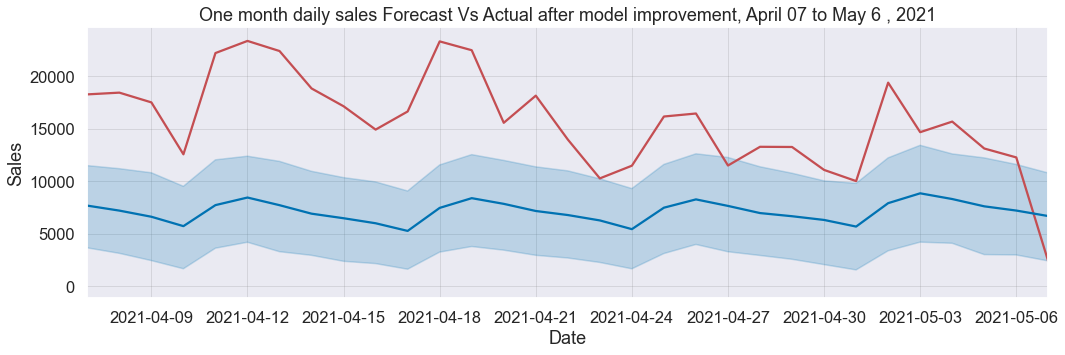

In [156]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-04-07', upper='2021-05-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

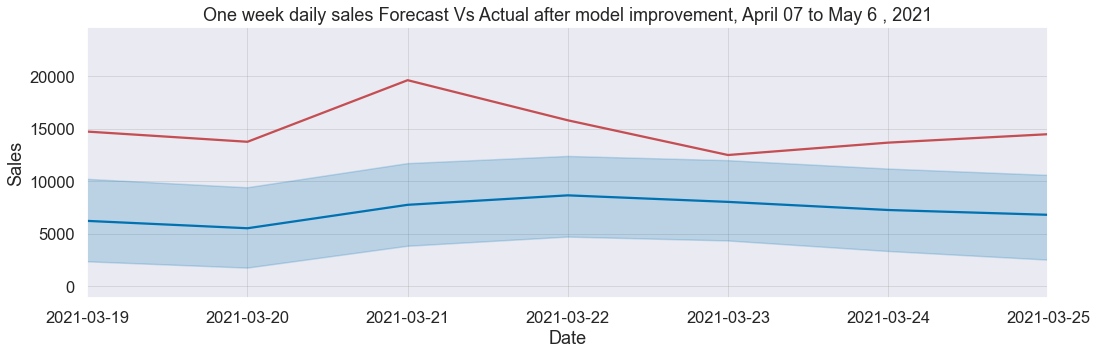

In [157]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-03-19', upper='2021-03-25')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One week daily sales Forecast Vs Actual after model improvement, April 07 to May 6 , 2021')

Text(0.5, 1.0, 'One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

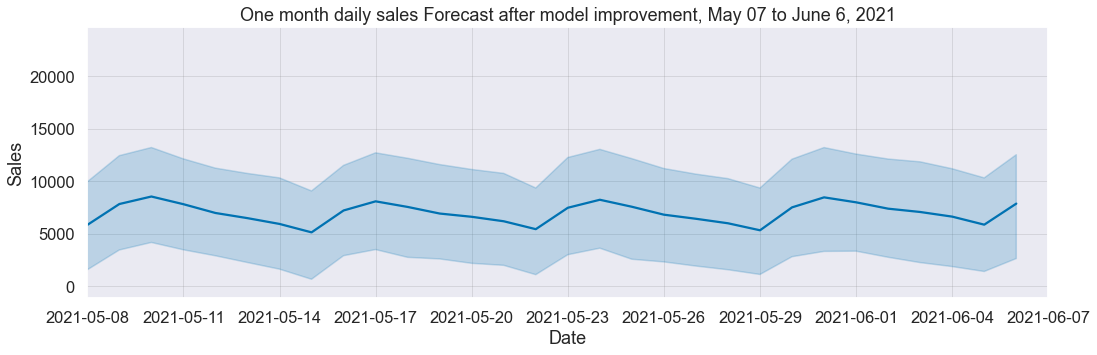

In [158]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(test_df['ds'], test_df['y'], color='r')
fig = final_model.plot(final_forecast, ax=ax)
ax.set_xbound(lower='2021-05-08', upper='2021-06-07')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')

plt.title('One month daily sales Forecast after model improvement, May 07 to June 6, 2021')

In [159]:
forecast_one=forecast[['ds', 'yhat']]
forecast_two=final_forecast[['ds', 'yhat']]
forecast_one.columns=['ds', 'yhat_one']
forecast_two.columns=['ds', 'yhat_two']
forecast_combined=pd.merge(forecast_one, forecast_two, on='ds')
forecast_combined.head()

,ds,yhat_one,yhat_two
0,2019-06-01,5268.410891,4980.358869
1,2019-06-02,7653.247632,6906.705466
2,2019-06-03,8673.245409,7654.811294
3,2019-06-04,8020.053362,7063.704347
4,2019-06-05,7253.898598,6365.830193


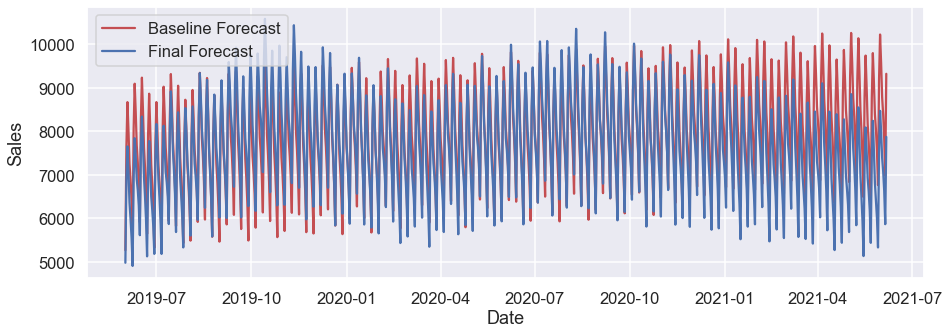

In [160]:
# Comparing the final forecast with the baseline forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.plot(forecast_combined['ds'], forecast_combined['yhat_one'], color='r', label='Baseline Forecast')
ax.plot(forecast_combined['ds'], forecast_combined['yhat_two'], color='b', label='Final Forecast')

plt.legend()
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.show()

